In [1]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import networkx as nx
import scipy
import sklearn
import sklearn.metrics
import time
import pickle

import gconcorde as cce

In [2]:
def get_precision(X):
    return .5*(np.diag(np.diag(X)) @ X) + .5*(X.T @ np.diag(np.diag(X)))

def mcc(B, B_hat, diag=False):
    """
    Compute Matthew's Correlation Coefficient (MCC) between two matrices.
    If diag=False, it excludes diagonal elements before computing MCC.
    """
    
    B_vec = B.ravel()
    B_hat_vec = B_hat.ravel()
    
    if diag:
        return sklearn.metrics.matthews_corrcoef(B_vec, B_hat_vec)

    p = len(B)
    indx = np.arange(0, p**2, p+1)
    B_vec = np.where(B_vec != 0, 1, 0)
    B_vec = np.delete(B_vec, indx)
    B_hat_vec = np.where(B_hat_vec != 0, 1, 0)
    B_hat_vec = np.delete(B_hat_vec, indx)
    
    return sklearn.metrics.matthews_corrcoef(B_vec, B_hat_vec)

def standardize(X, bias=False):
    X_std = X.copy()
    X_std -= X_std.mean(axis=0)
    if bias:
        X_std /= X_std.std(axis=0)
    else:
        X_std /= X_std.std(axis=0, ddof=1)
    
    return X_std

def omega_to_corr(A):
    std_inv = np.diag(np.sqrt(1/np.diag(A)))
    A_corr = -1 * (std_inv @ A @ std_inv)
    np.fill_diagonal(A_corr, 1)
    
    return A_corr

In [3]:
# erdos-renyi

# number of variables
p = 5000
# number of datasets
N = 1
# n = n_prop_to_p * p
n_prop_to_p = [0.2] # [0.2, 1.2, 5]
edge_prob = 0.03 # [0.03, 0.15]
random_state = 2022
lower_weight, upper_weight = 0.5, 1.0
spread_diag=[1, np.sqrt(3)]
G = nx.generators.random_graphs.erdos_renyi_graph(n=p, p=edge_prob, seed=random_state)
Skel = nx.to_numpy_matrix(G)

# Peng's method (ensuring positive definiteness of precision matrix)
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Omega = np.multiply(edge_weights, edge_signs)
Omega = np.multiply(Skel, Omega)
Omega = np.tril(Omega) + np.tril(Omega).T
np.fill_diagonal(Omega, 1.5*np.abs(Omega).sum(1))
diag_inv = np.diag(1/np.sqrt(np.diag(Omega)))
Omega = diag_inv @ Omega @ diag_inv

# spread diagonal of precision matrix
d = np.random.uniform(spread_diag[0], spread_diag[1], p)
Omega = np.diag(d) @ Omega @ np.diag(d)
Cov = np.linalg.inv(Omega)
Omega_corr = omega_to_corr(Omega)

# generate Gaussian data
Xs = []
for this in n_prop_to_p:
    n = int(this*p)
    for j in range(N):
        rs = np.random.RandomState(random_state)
        X = rs.multivariate_normal(mean=np.zeros(p), cov=Cov, size=n)
        # X_std = standardize(X, bias=False)
        Xs.append(X)
        random_state += 1
        
# choose length of grid for lambda
num_lams = 10

In [4]:
# search for lambda
S = np.matmul(Xs[0].T, Xs[0], dtype=np.float64)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 10)
lams

array([0.01423695, 0.01838773, 0.02374866, 0.03067257, 0.03961515,
       0.05116494, 0.06608206, 0.08534826, 0.11023152, 0.14236948])

In [5]:
# obtain Omega_star from cce_constant
S = np.matmul(Xs[0].T, Xs[0])/n
lam = 0.05
Omega_star_ccel, hist_ccel = cce.cce_constant(S, Cov, lam, False, 1, np.eye(p), epstol=1e-8, maxitr=5000, penalize_diagonal=True)
Omega_star_ccel = Omega_star_ccel.todense()
print(mcc(Omega, get_precision(Omega_star_ccel)))
print(len(np.flatnonzero(Omega))) 
print(len(np.flatnonzero(get_precision(Omega_star_ccel))))

0.0018850497328676895
752552
996622


In [ ]:
# save
pickle.dump(Omega_star_ccel, open('Omega_star_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'wb'))

# load
# Omega_star_ccel = pickle.load(open('Omega_star_p' +  str(p) + '_n' + str(n) + '_sp' + str(edge_prob)[2:] +'_lam' + str(lam)[2:] + '.pkl', 'rb'))

In [12]:
# re-fit cce_constant with Omega_star
Omega_hat_ccel, hist_ccel_1L = cce.cce_constant(S, Cov, lam, False, 1, Omega_star_ccel, epstol=1e-6, maxitr=5000, penalize_diagonal=True)
Omega_hat_ccel, hist_ccel_2L = cce.cce_constant(S, Cov, lam, False, 2, Omega_star_ccel, epstol=1e-6, maxitr=5000, penalize_diagonal=True)
Omega_hat_cce, hist_cce = cce.cceista(S, lam, Omega_star_ccel, epstol=1e-6, maxitr=5000, penalize_diagonal=True)

In [8]:
print('total # of iter')
print('concorde-2L:', len(hist_ccel_2L))
print('concorde-1L:', len(hist_ccel_1L))
print('concorde-ista:', len(hist_cce))

total # of iter
concorde-2L: 161
concorde-1L: 307
concorde-ista: 57


In [9]:
# || Omega^(t) - Omega^* ||
omega_star_norm_ccel_1L = [np.linalg.norm(np.eye(p) - Omega_star_ccel)]
for i in range(len(hist_ccel_1L)):
    omega_star_norm_ccel_1L.append(hist_ccel_1L[i,-2])

omega_star_norm_ccel_2L = [np.linalg.norm(np.eye(p) - Omega_star_ccel)]
for i in range(len(hist_ccel_2L)):
    omega_star_norm_ccel_2L.append(hist_ccel_2L[i,-2])

omega_star_norm_cce = [np.linalg.norm(np.eye(p) - Omega_star_ccel)]
for i in range(len(hist_cce)):
    omega_star_norm_cce.append(hist_cce[i,-2])

In [10]:
# cum iter time
time_took_per_iter_ccel_1L = []
for i in range(len(hist_ccel_1L)):
    time_took_per_iter_ccel_1L.append(hist_ccel_1L[i][-1])
time_took_cumsum_ccel_1L = np.cumsum(time_took_per_iter_ccel_1L)
time_took_cumsum_ccel_1L = np.insert(time_took_cumsum_ccel_1L, 0, 0)

time_took_per_iter_ccel_2L = []
for i in range(len(hist_ccel_2L)):
    time_took_per_iter_ccel_2L.append(hist_ccel_2L[i][-1])
time_took_cumsum_ccel_2L = np.cumsum(time_took_per_iter_ccel_2L)
time_took_cumsum_ccel_2L = np.insert(time_took_cumsum_ccel_2L, 0, 0)

time_took_per_iter_cce = []
for i in range(len(hist_cce)):
    time_took_per_iter_cce.append(hist_cce[i][-1])
time_took_cumsum_cce = np.cumsum(time_took_per_iter_cce)
time_took_cumsum_cce = np.insert(time_took_cumsum_cce, 0, 0)

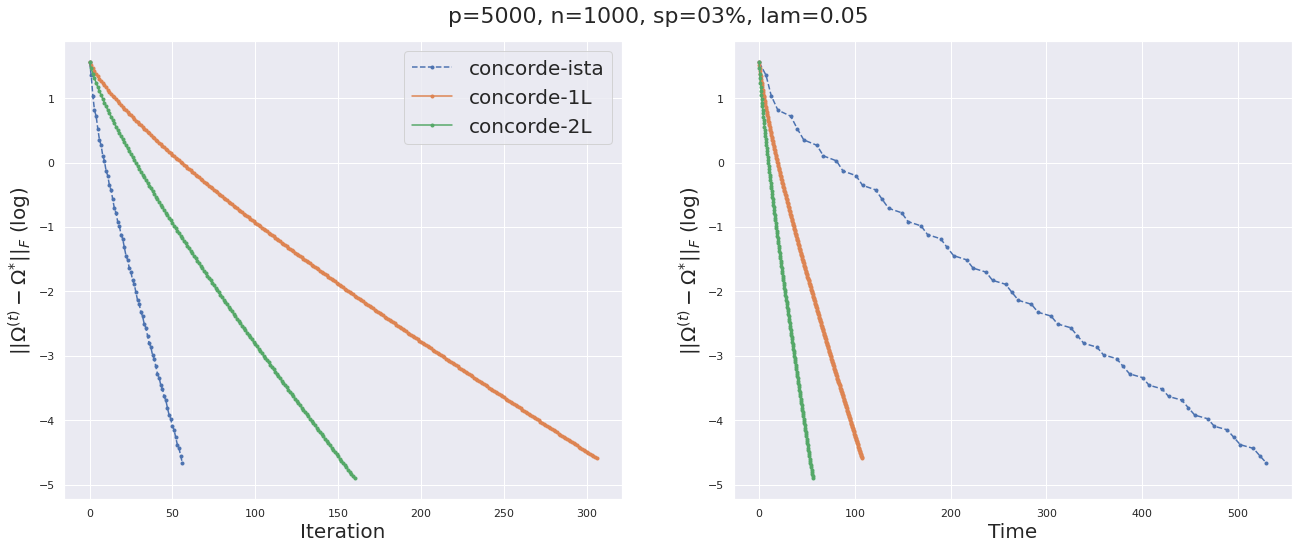

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

for i in range(2):
    if i == 0:
        axes[i].plot(np.arange(len(omega_star_norm_cce)-1), np.log10(omega_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(np.arange(len(omega_star_norm_ccel_1L)-1), np.log10(omega_star_norm_ccel_1L[:-1]), label='concorde-1L', marker='.')
        axes[i].plot(np.arange(len(omega_star_norm_ccel_2L)-1), np.log10(omega_star_norm_ccel_2L[:-1]), label='concorde-2L', marker='.')
        axes[i].legend(fontsize=20, loc='upper right')
        axes[i].set_xlabel('Iteration', fontsize=20)
        axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$ (log)', fontsize=20)
    elif i == 1:
        axes[i].plot(time_took_cumsum_cce[:-1], np.log10(omega_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(time_took_cumsum_ccel_1L[:-1], np.log10(omega_star_norm_ccel_1L[:-1]), label='concorde-1L', marker='.')
        axes[i].plot(time_took_cumsum_ccel_2L[:-1], np.log10(omega_star_norm_ccel_2L[:-1]), label='concorde-2L', marker='.')
        axes[i].set_xlabel('Time', fontsize=20)
        axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$ (log)', fontsize=20)
fig.suptitle('p=' + str(p) + ', n=' + str(n) + ', sp=' + str(edge_prob)[2:] + '%, lam=' + str(lam), fontsize=22)
fig.subplots_adjust(top=0.92);

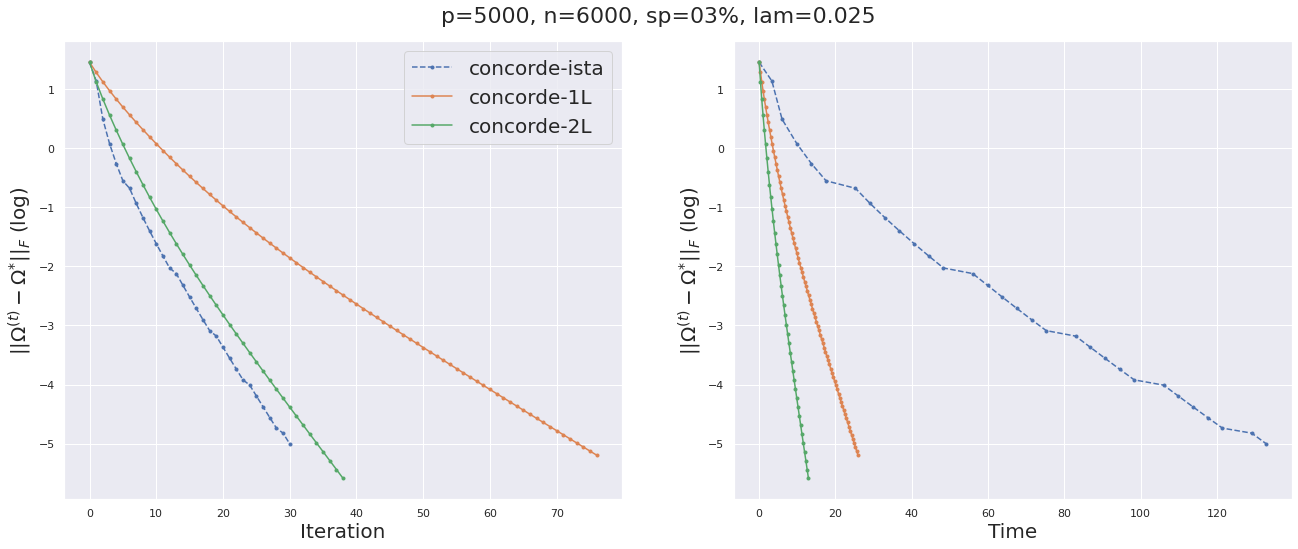

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

for i in range(2):
    if i == 0:
        axes[i].plot(np.arange(len(omega_star_norm_cce)-1), np.log10(omega_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(np.arange(len(omega_star_norm_ccel_1L)-1), np.log10(omega_star_norm_ccel_1L[:-1]), label='concorde-1L', marker='.')
        axes[i].plot(np.arange(len(omega_star_norm_ccel_2L)-1), np.log10(omega_star_norm_ccel_2L[:-1]), label='concorde-2L', marker='.')
        axes[i].legend(fontsize=20, loc='upper right')
        axes[i].set_xlabel('Iteration', fontsize=20)
        axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$ (log)', fontsize=20)
    elif i == 1:
        axes[i].plot(time_took_cumsum_cce[:-1], np.log10(omega_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(time_took_cumsum_ccel_1L[:-1], np.log10(omega_star_norm_ccel_1L[:-1]), label='concorde-1L', marker='.')
        axes[i].plot(time_took_cumsum_ccel_2L[:-1], np.log10(omega_star_norm_ccel_2L[:-1]), label='concorde-2L', marker='.')
        axes[i].set_xlabel('Time', fontsize=20)
        axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$ (log)', fontsize=20)
fig.suptitle('p=' + str(p) + ', n=' + str(n) + ', sp=' + str(edge_prob)[2:] + '%, lam=' + str(lam), fontsize=22)
fig.subplots_adjust(top=0.92);

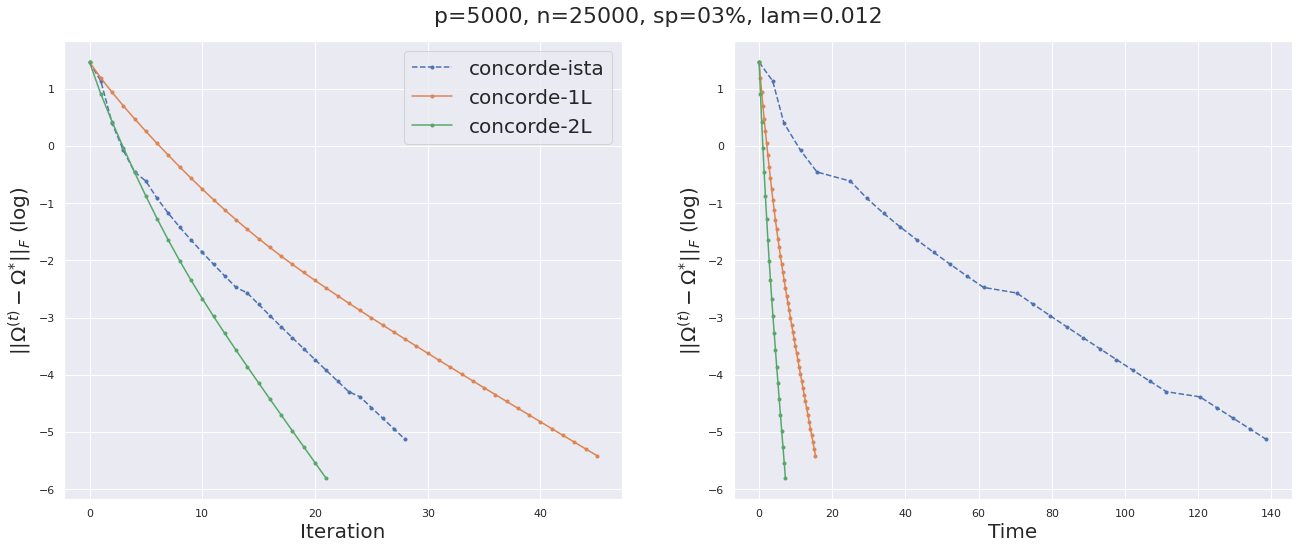

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
axes = axes.ravel()

for i in range(2):
    if i == 0:
        axes[i].plot(np.arange(len(omega_star_norm_cce)-1), np.log10(omega_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(np.arange(len(omega_star_norm_ccel_1L)-1), np.log10(omega_star_norm_ccel_1L[:-1]), label='concorde-1L', marker='.')
        axes[i].plot(np.arange(len(omega_star_norm_ccel_2L)-1), np.log10(omega_star_norm_ccel_2L[:-1]), label='concorde-2L', marker='.')
        axes[i].legend(fontsize=20, loc='upper right')
        axes[i].set_xlabel('Iteration', fontsize=20)
        axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$ (log)', fontsize=20)
    elif i == 1:
        axes[i].plot(time_took_cumsum_cce[:-1], np.log10(omega_star_norm_cce[:-1]), label='concorde-ista', linestyle='--', marker='.')
        axes[i].plot(time_took_cumsum_ccel_1L[:-1], np.log10(omega_star_norm_ccel_1L[:-1]), label='concorde-1L', marker='.')
        axes[i].plot(time_took_cumsum_ccel_2L[:-1], np.log10(omega_star_norm_ccel_2L[:-1]), label='concorde-2L', marker='.')
        axes[i].set_xlabel('Time', fontsize=20)
        axes[i].set_ylabel('$|| \Omega^{(t)} - \Omega^{*} ||_F$ (log)', fontsize=20)
fig.suptitle('p=' + str(p) + ', n=' + str(n) + ', sp=' + str(edge_prob)[2:] + '%, lam=' + str(lam), fontsize=22)
fig.subplots_adjust(top=0.92);